# Modelos de Difusión: Fundamentos desde Cero

## Objetivo de este Notebook

Este notebook está diseñado para aprendices de Machine Learning que quieren entender **cómo funcionan los modelos de difusión** desde los primeros principios. Construiremos un modelo de difusión simple desde cero para generar imágenes.

### ¿Qué aprenderás?

1. La intuición detrás de los modelos de difusión
2. El proceso forward (añadir ruido gradualmente)
3. El proceso reverse (eliminar ruido con una red neuronal)
4. Cómo entrenar un modelo de difusión simple
5. Cómo generar nuevas imágenes desde ruido aleatorio

### Pre-requisitos

- Conocimientos básicos de Python y NumPy
- Familiaridad con redes neuronales (PyTorch)
- Conceptos básicos de probabilidad (distribución gaussiana)

---

## 1. Instalación e Importación de Librerías

Primero instalemos las librerías necesarias:

In [1]:
# Instalar dependencias (descomenta si es necesario)
!pip install torch torchvision numpy matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 53.3 MB/s  0:00:27 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 57.5 MB/s  0:00:09 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 58.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 58.8 MB/s  0:00:01 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 33.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 35.2 MB/s  0:00:14 eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 45.3 MB/s  0:00:04 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 37.7 MB/s  0:00:01 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 60.6 MB/s  0:00:04 eta 0:00:010:01:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 61.0 MB/s  0:00:04 eta 0:00:010:00:01


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configurar el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## 2. Intuición: ¿Qué es un Modelo de Difusión?

Imagina que tienes una foto clara de un gato. Si le añades ruido poco a poco, eventualmente se convertirá en ruido puro (estática). Un modelo de difusión aprende el proceso **inverso**: toma ruido aleatorio y lo convierte gradualmente en una imagen clara.

```
Imagen Clara → [+ ruido] → [+ ruido] → ... → Ruido Puro
     x₀           x₁           x₂              x_T
```

El modelo aprende a:
```
Ruido Puro → [- ruido] → [- ruido] → ... → Imagen Clara
    x_T          x_{T-1}     x_{T-2}           x₀
```

### Componentes clave:

1. **Forward Process (Difusión)**: Añadir ruido gradualmente (no requiere aprendizaje)
2. **Reverse Process (Denoising)**: Eliminar ruido gradualmente (RED NEURONAL)
3. **Noise Schedule**: Cuánto ruido añadir en cada paso

## 3. Implementando el Forward Process

El forward process añade ruido gaussiano gradualmente. Matemáticamente:

$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$$

Donde:
- $\beta_t$ es la cantidad de ruido en el paso $t$
- $\mathcal{N}$ es una distribución normal

**Truco importante**: Podemos ir directamente de $x_0$ a $x_t$ sin pasar por todos los pasos intermedios:

$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$$

donde $\epsilon \sim \mathcal{N}(0, I)$ y $\bar{\alpha}_t = \prod_{i=1}^{t}(1-\beta_i)$

In [3]:
class DiffusionSchedule:
    """Gestiona el schedule de ruido para el proceso de difusión"""
    
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        """
        Args:
            num_timesteps: Número de pasos de difusión (T)
            beta_start: Valor inicial de beta (poco ruido)
            beta_end: Valor final de beta (mucho ruido)
        """
        self.num_timesteps = num_timesteps
        self.device = device
        
        # Linear schedule de betas
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        
        # Calcular alphas
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # Calcular valores útiles para el forward process
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        
        # Calcular valores para el reverse process
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        
        # Varianza del reverse process
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
    
    def add_noise(self, x_0, t, noise=None):
        """
        Añade ruido a x_0 para obtener x_t (forward process)
        
        Args:
            x_0: Imágenes originales [batch_size, C, H, W]
            t: Timesteps [batch_size]
            noise: Ruido a añadir (si None, se genera aleatoriamente)
        
        Returns:
            x_t: Imágenes con ruido
        """
        if noise is None:
            noise = torch.randn_like(x_0)
        
        # Extraer valores para el timestep específico
        sqrt_alpha_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alpha_cumprod_t = self._extract(
            self.sqrt_one_minus_alphas_cumprod, t, x_0.shape
        )
        
        # Aplicar la fórmula: x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
        return sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise
    
    def _extract(self, a, t, x_shape):
        """Extrae valores de 'a' en índices 't' y los reshape para broadcasting"""
        batch_size = t.shape[0]
        out = a.gather(-1, t)
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

# Crear el schedule
schedule = DiffusionSchedule(num_timesteps=1000, device=device)
print(f"Schedule creado con {schedule.num_timesteps} timesteps")

Schedule creado con 1000 timesteps


## 4. Visualizar el Forward Process

Veamos cómo una imagen se convierte gradualmente en ruido:

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.44MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 208kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.12MB/s]


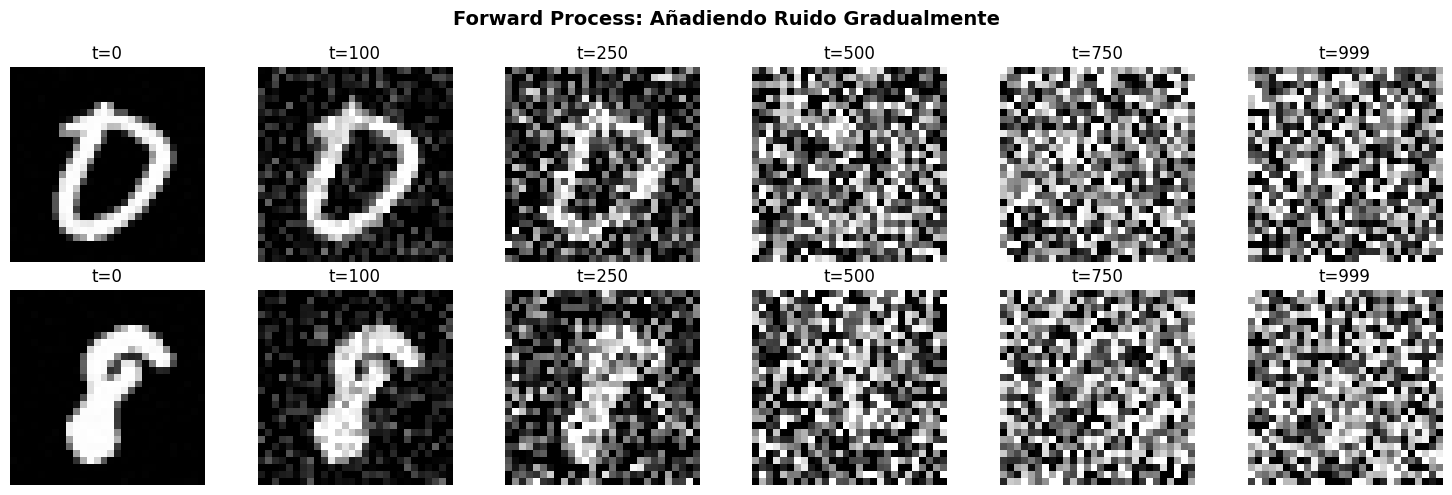

Observa cómo la imagen se corrompe gradualmente hasta convertirse en ruido puro.


In [4]:
# Cargar una imagen de ejemplo (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizar a [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Obtener una imagen
x_0, _ = next(iter(dataloader))
x_0 = x_0.to(device)

# Visualizar el forward process en diferentes timesteps
timesteps_to_show = [0, 100, 250, 500, 750, 999]
fig, axes = plt.subplots(2, 6, figsize=(15, 5))

for idx, t_val in enumerate(timesteps_to_show):
    # Añadir ruido
    t = torch.full((x_0.shape[0],), t_val, device=device, dtype=torch.long)
    x_t = schedule.add_noise(x_0, t)
    
    # Mostrar dos ejemplos
    for row in range(2):
        img = x_t[row].cpu().squeeze().numpy()
        axes[row, idx].imshow(img, cmap='gray', vmin=-1, vmax=1)
        axes[row, idx].set_title(f't={t_val}')
        axes[row, idx].axis('off')

plt.suptitle('Forward Process: Añadiendo Ruido Gradualmente', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Observa cómo la imagen se corrompe gradualmente hasta convertirse en ruido puro.")

## 5. Diseñar la Red Neuronal (U-Net Simple)

Para el reverse process, necesitamos una red neuronal que:
1. Tome una imagen ruidosa $x_t$ y el timestep $t$
2. Prediga el ruido $\epsilon$ que se añadió

Usaremos una arquitectura U-Net simplificada, que es común en modelos de difusión.

In [5]:
class SinusoidalPositionEmbeddings(nn.Module):
    """Embedding de posición sinusoidal para el timestep"""
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUNet(nn.Module):
    """U-Net simplificada para predecir ruido"""
    
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=32):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        # Encoder (downsampling)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Bottleneck
        self.bottleneck = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        # Decoder (upsampling)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)  # 128 porque concatenamos con skip
        
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        
        # Output
        self.out = nn.Conv2d(32, out_channels, kernel_size=1)
        
        # Time embedding projection layers
        self.time_proj1 = nn.Linear(time_emb_dim, 32)
        self.time_proj2 = nn.Linear(time_emb_dim, 64)
        self.time_proj3 = nn.Linear(time_emb_dim, 128)
    
    def forward(self, x, t):
        """
        Args:
            x: Imagen con ruido [batch_size, C, H, W]
            t: Timesteps [batch_size]
        
        Returns:
            Ruido predicho [batch_size, C, H, W]
        """
        # Time embedding
        t_emb = self.time_mlp(t)
        
        # Encoder
        x1 = F.relu(self.conv1(x))
        x1 = x1 + self.time_proj1(t_emb)[:, :, None, None]
        
        x2 = F.max_pool2d(x1, 2)
        x2 = F.relu(self.conv2(x2))
        x2 = x2 + self.time_proj2(t_emb)[:, :, None, None]
        
        x3 = F.max_pool2d(x2, 2)
        x3 = F.relu(self.conv3(x3))
        x3 = x3 + self.time_proj3(t_emb)[:, :, None, None]
        
        # Bottleneck
        x = F.relu(self.bottleneck(x3))
        
        # Decoder con skip connections
        x = self.upconv3(x)
        x = torch.cat([x, x2], dim=1)  # Skip connection
        x = F.relu(self.conv4(x))
        
        x = self.upconv2(x)
        x = torch.cat([x, x1], dim=1)  # Skip connection
        x = F.relu(self.conv5(x))
        
        return self.out(x)


# Crear el modelo
model = SimpleUNet().to(device)
print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 382049 parámetros


## 6. Entrenar el Modelo de Difusión

El objetivo de entrenamiento es simple: **predecir el ruido que se añadió**.

Loss function:
$$L = \mathbb{E}_{t, x_0, \epsilon} \left[ \|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]$$

Donde:
- $\epsilon$ es el ruido real que añadimos
- $\epsilon_\theta(x_t, t)$ es el ruido predicho por el modelo

Iniciando entrenamiento...
Nota: Para mejores resultados, entrena por más épocas (10-20)


Epoch 1/8: 100%|██████████| 938/938 [01:39<00:00,  9.42it/s, loss=0.0314]


Epoch 1: Average Loss = 0.0277


Epoch 2/8: 100%|██████████| 938/938 [01:34<00:00,  9.89it/s, loss=0.0231]


Epoch 2: Average Loss = 0.0272


Epoch 3/8: 100%|██████████| 938/938 [01:32<00:00, 10.13it/s, loss=0.0299]


Epoch 3: Average Loss = 0.0269


Epoch 4/8: 100%|██████████| 938/938 [01:38<00:00,  9.53it/s, loss=0.0209]


Epoch 4: Average Loss = 0.0268


Epoch 5/8: 100%|██████████| 938/938 [01:34<00:00,  9.91it/s, loss=0.0325]


Epoch 5: Average Loss = 0.0267


Epoch 6/8: 100%|██████████| 938/938 [01:30<00:00, 10.34it/s, loss=0.0323]


Epoch 6: Average Loss = 0.0266


Epoch 7/8: 100%|██████████| 938/938 [01:33<00:00,  9.98it/s, loss=0.0293]


Epoch 7: Average Loss = 0.0264


Epoch 8/8: 100%|██████████| 938/938 [01:35<00:00,  9.82it/s, loss=0.0207]


Epoch 8: Average Loss = 0.0264


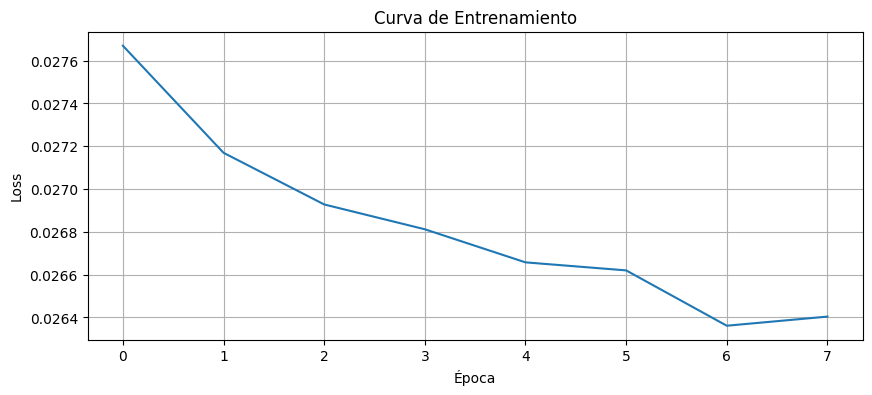

In [13]:
def train_diffusion_model(model, schedule, dataloader, epochs=5, lr=1e-3):
    """
    Entrena el modelo de difusión
    
    Args:
        model: La red neuronal (U-Net)
        schedule: El schedule de difusión
        dataloader: DataLoader con imágenes de entrenamiento
        epochs: Número de épocas
        lr: Learning rate
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch_idx, (x_0, _) in enumerate(progress_bar):
            x_0 = x_0.to(device)
            batch_size = x_0.shape[0]
            
            # 1. Samplear timesteps aleatorios para cada imagen
            t = torch.randint(0, schedule.num_timesteps, (batch_size,), device=device).long()
            
            # 2. Generar ruido aleatorio
            noise = torch.randn_like(x_0)
            
            # 3. Añadir ruido a las imágenes (forward process)
            x_t = schedule.add_noise(x_0, t, noise)
            
            # 4. Predecir el ruido con el modelo
            noise_pred = model(x_t, t)
            
            # 5. Calcular loss (diferencia entre ruido real y predicho)
            loss = loss_fn(noise_pred, noise)
            
            # 6. Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}: Average Loss = {avg_loss:.4f}')
    
    return losses


# Entrenar el modelo (usa menos épocas para experimentación rápida)
print("Iniciando entrenamiento...")
print("Nota: Para mejores resultados, entrena por más épocas (10-20)")
losses = train_diffusion_model(model, schedule, dataloader, epochs=8, lr=1e-3)

# Visualizar la curva de loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Entrenamiento')
plt.grid(True)
plt.show()

## 7. Generar Nuevas Imágenes (Sampling)

Ahora viene la parte emocionante: generar imágenes desde ruido aleatorio.

Algoritmo de sampling:
1. Empezar con ruido puro $x_T \sim \mathcal{N}(0, I)$
2. Para $t = T, T-1, ..., 1$:
   - Predecir el ruido: $\epsilon_\theta(x_t, t)$
   - Calcular $x_{t-1}$ usando la predicción
3. Devolver $x_0$

Generando nuevas imágenes...


Sampling: 100%|██████████| 1000/1000 [00:06<00:00, 147.08it/s]


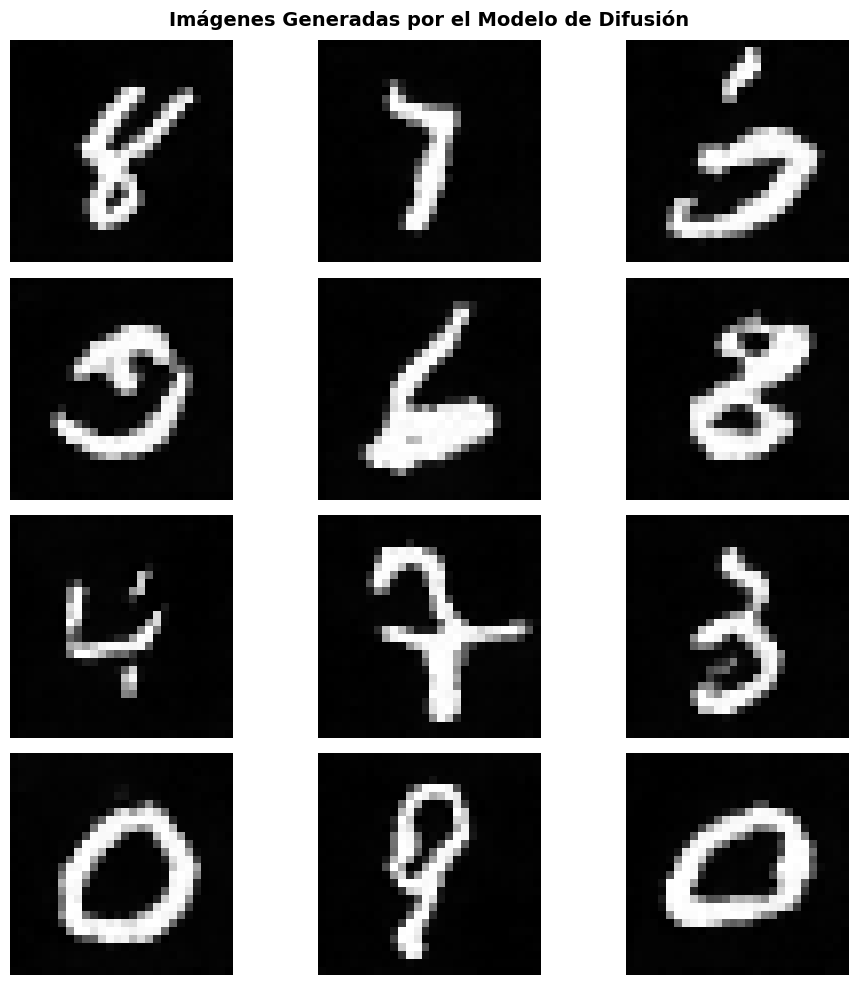

In [14]:
@torch.no_grad()
def sample(model, schedule, image_size=(1, 28, 28), num_images=16):
    """
    Genera nuevas imágenes desde ruido aleatorio
    
    Args:
        model: Modelo entrenado
        schedule: Schedule de difusión
        image_size: Tamaño de las imágenes a generar
        num_images: Número de imágenes a generar
    
    Returns:
        Imágenes generadas
    """
    model.eval()
    
    # Empezar con ruido puro
    x = torch.randn(num_images, *image_size, device=device)
    
    # Lista para guardar pasos intermedios (para visualización)
    steps_to_save = [999, 750, 500, 250, 100, 0]
    saved_steps = {}
    
    # Reverse process
    for t in tqdm(reversed(range(schedule.num_timesteps)), desc='Sampling', total=schedule.num_timesteps):
        # Crear tensor de timestep
        t_tensor = torch.full((num_images,), t, device=device, dtype=torch.long)
        
        # Predecir ruido
        predicted_noise = model(x, t_tensor)
        
        # Extraer valores necesarios
        alpha_t = schedule.alphas[t]
        alpha_bar_t = schedule.alphas_cumprod[t]
        beta_t = schedule.betas[t]
        
        # Calcular x_{t-1}
        # Fórmula: x_{t-1} = 1/sqrt(alpha_t) * (x_t - (1-alpha_t)/sqrt(1-alpha_bar_t) * epsilon_theta)
        x = (1 / torch.sqrt(alpha_t)) * (
            x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise
        )
        
        # Añadir ruido si no estamos en el último paso
        if t > 0:
            noise = torch.randn_like(x)
            x = x + torch.sqrt(beta_t) * noise
        
        # Guardar pasos intermedios
        if t in steps_to_save:
            saved_steps[t] = x.clone().cpu()
    
    model.train()
    return x.cpu(), saved_steps


# Generar imágenes
print("Generando nuevas imágenes...")
generated_images, intermediate_steps = sample(model, schedule, num_images=12)

# Visualizar las imágenes generadas
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = generated_images[i].squeeze().numpy()
    ax.imshow(img, cmap='gray', vmin=-1, vmax=1)
    ax.axis('off')

plt.suptitle('Imágenes Generadas por el Modelo de Difusión', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Visualizar el Proceso de Denoising

Veamos cómo el modelo elimina ruido gradualmente:

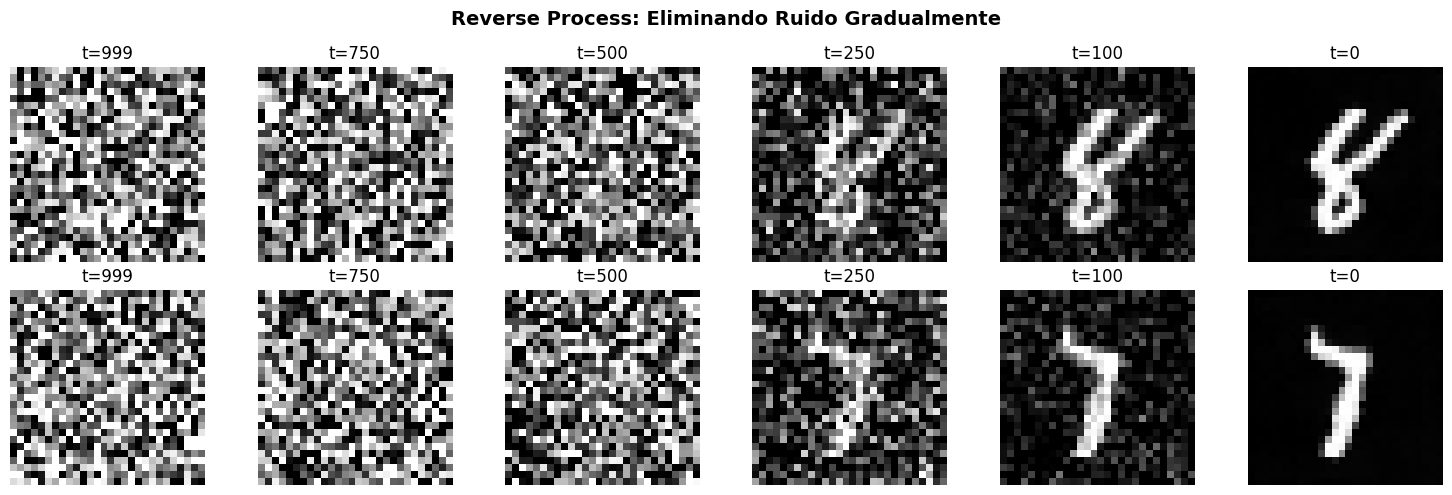

Observa cómo el ruido puro gradualmente se convierte en dígitos reconocibles.


In [15]:
# Visualizar el proceso de denoising
steps_to_show = [999, 750, 500, 250, 100, 0]
fig, axes = plt.subplots(2, 6, figsize=(15, 5))

for idx, t_val in enumerate(steps_to_show):
    if t_val in intermediate_steps:
        images_at_t = intermediate_steps[t_val]
        
        # Mostrar dos ejemplos
        for row in range(2):
            img = images_at_t[row].squeeze().numpy()
            axes[row, idx].imshow(img, cmap='gray', vmin=-1, vmax=1)
            axes[row, idx].set_title(f't={t_val}')
            axes[row, idx].axis('off')

plt.suptitle('Reverse Process: Eliminando Ruido Gradualmente', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Observa cómo el ruido puro gradualmente se convierte en dígitos reconocibles.")

## 9. Resumen y Conceptos Clave

### ¿Qué aprendimos?

1. **Forward Process**: Añadir ruido gradualmente a los datos
   - No requiere aprendizaje
   - Controlado por un schedule de ruido ($\beta_t$)

2. **Reverse Process**: Eliminar ruido usando una red neuronal
   - La red aprende a predecir el ruido añadido
   - Arquitectura común: U-Net con time embeddings

3. **Entrenamiento**: Minimizar la diferencia entre ruido real y predicho
   - Loss: MSE entre $\epsilon$ y $\epsilon_\theta(x_t, t)$

4. **Sampling**: Generar nuevas imágenes desde ruido
   - Empezar con ruido puro
   - Aplicar el reverse process iterativamente

### Ventajas de los Modelos de Difusión

- Entrenamiento más estable que GANs
- Generación de alta calidad
- Fácil de condicionar (texto, clase, etc.)
- No sufren de mode collapse

### Desventajas

- Sampling lento (requiere muchos pasos)
- Requiere más memoria que otros métodos

### Próximos Pasos

- Implementar conditional diffusion (guiado por clase o texto)
- Explorar diferentes schedules de ruido
- Usar modelos más grandes (Stable Diffusion, DALL-E)
- Acelerar el sampling (DDIM, DPM-Solver)

## 10. Ejercicios para Practicar

1. **Modificar el schedule**: Cambia `beta_start` y `beta_end`. ¿Cómo afecta esto a la calidad?

2. **Entrenar por más tiempo**: Aumenta el número de épocas a 20. ¿Mejoran las imágenes?

3. **Usar otro dataset**: Prueba con CIFAR-10 o Fashion-MNIST

4. **Añadir condicionamiento**: Modifica el modelo para generar dígitos específicos

5. **Experimentar con timesteps**: Reduce el número de timesteps durante sampling. ¿Qué pasa?

## Referencias

- [Denoising Diffusion Probabilistic Models (Ho et al., 2020)](https://arxiv.org/abs/2006.11239)
- [Understanding Diffusion Models (Luo, 2022)](https://arxiv.org/abs/2208.11970)
- [The Annotated Diffusion Model](https://huggingface.co/blog/annotated-diffusion)